In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pytorch_eo.datasets import SEN12Floods
from pytorch_eo.datasets.big_earth_net import BigEarthNet
from pytorch_eo.datasets.big_earth_net.utils import LABELS19
from pytorch_eo.datasets.sensors import Sensors, S1, S2

import lightning as L
from sklearn.metrics import average_precision_score
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from einops import rearrange
from pytorch_eo.tasks.classification import ImageClassification
import timm
import torch

/Users/fran/Documents/Projects/pytorchEO/.venv/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# SEN12-FLOODS

In this example we are going to train 2 image classifiers using the [SEN12-FLOODS](https://mlhub.earth/data/sen12floods) dataset:

1. Using S1 images
2. Using S2 images

This dataset needs to be downloaded from the [SEN12-FLOOD Radian MLHUB](https://mlhub.earth/data/sen12floods) website. Once downloaded you will need a folder with the following structure:

- sen12floods_s1_labels
- sen12floods_s1_source 
- sen12floods_s2_labels
- sen12floods_s2_source

Then you can instantiate the Dataset as follows, selecting the sensors and bands that you want to work with.

## Sentinel-1

In [3]:
trans = A.Compose([
    A.Resize(64,64)                           
])

ds = SEN12Floods(batch_size=25,
                 verbose=True, 
                 sensor=Sensors.S1,
                 bands=[S1.VH, S1.VV], 
                 train_trans=trans,
                ) 

ds.setup()

Number of images: 3331
Training samples 1999
Validation samples 666
Test samples 666


In [4]:
ds.df

,image,label
0,/Users/fran/Documents/datasets/sen12floods/sen...,0
1,/Users/fran/Documents/datasets/sen12floods/sen...,0
2,/Users/fran/Documents/datasets/sen12floods/sen...,0
3,/Users/fran/Documents/datasets/sen12floods/sen...,0
4,/Users/fran/Documents/datasets/sen12floods/sen...,1
...,...,...
3326,/Users/fran/Documents/datasets/sen12floods/sen...,0
3327,/Users/fran/Documents/datasets/sen12floods/sen...,0
3328,/Users/fran/Documents/datasets/sen12floods/sen...,0
3329,/Users/fran/Documents/datasets/sen12floods/sen...,0


In [5]:
ds.num_classes, ds.classes

(2, ['NO_FLOODING', 'FLOODING'])

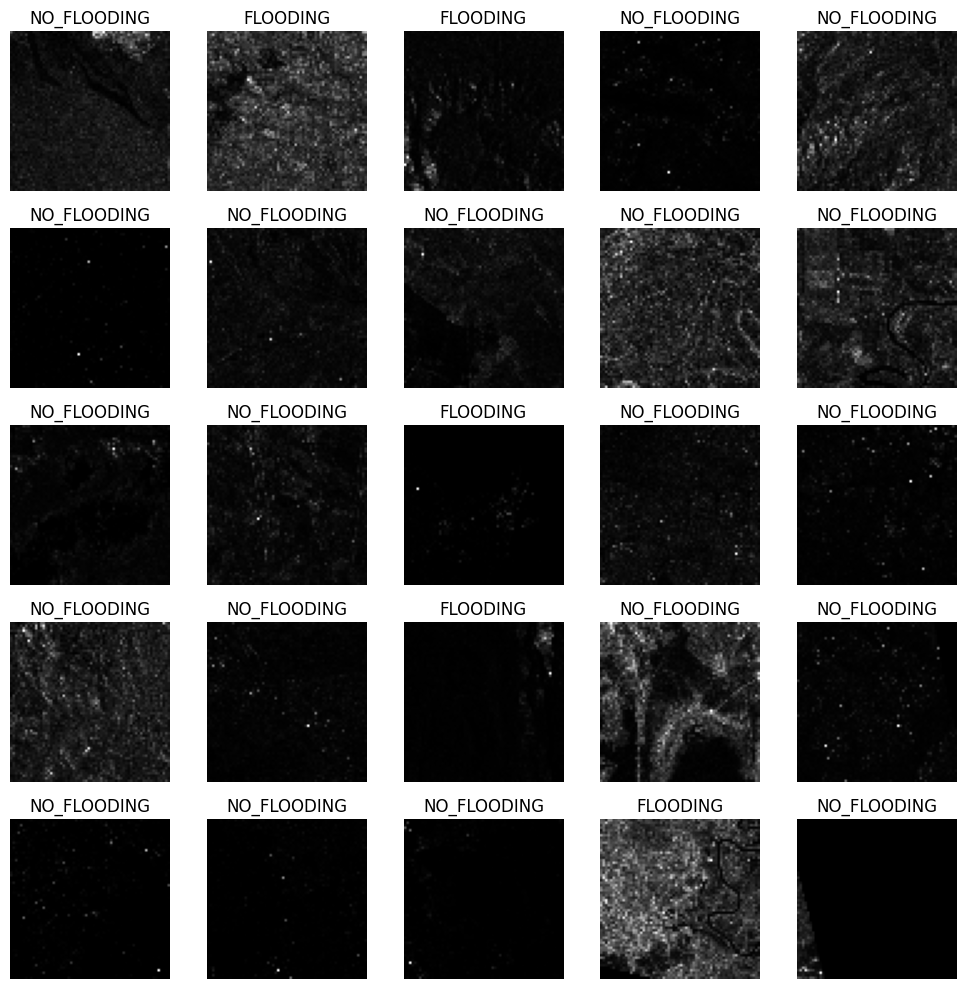

In [6]:
import matplotlib.pyplot as plt

batch = next(iter(ds.train_dataloader()))
imgs, labels = batch['image'], batch['label']

fig = plt.figure(figsize=(10, 10))
for i, (img, label) in enumerate(zip(imgs, labels)):
    ax = plt.subplot(5, 5, i + 1)
    if img.ndim == 2:
        ax.imshow(img, cmap="gray") # one band 
    else:
        ax.imshow(img[...,0], cmap="gray") # first band
    ax.set_title(ds.classes[label.item()])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [7]:
def clip(x, **kwargs): return np.clip(10**(x / 10), 0., 1.)
def add_channel(x, **kwargs): return rearrange(x, 'h w -> h w 1') if x.ndim == 2 else x

trans = A.Compose([
    A.Resize(64,64),
    A.Lambda(image=clip),    
    A.Lambda(image=add_channel),                           
    ToTensorV2()                                
])

ds = SEN12Floods(batch_size=64,
                 verbose=True, 
                 sensor=Sensors.S1,
                 bands=[S1.VH, S1.VV], 
                 train_trans=trans,
                 val_trans=trans,
                 pin_memory=True,
                ) 

ds.setup()

model = timm.create_model('resnet18', pretrained=True, num_classes=ds.num_classes, in_chans=ds.num_bands)

hparams = {
    'optimizer': 'Adam',
    'optim_params': {
        'lr': 1e-4,
    }
}

def my_map(y_hat, y):
    return average_precision_score(y.cpu(), torch.sigmoid(y_hat).detach().cpu(), average='micro')

task = ImageClassification(num_classes=ds.num_classes , model=model, hparams=hparams)

trainer = L.Trainer(
    devices=1,
    accelerator='gpu',
    max_epochs=3,
)

torch.set_float32_matmul_precision('high') # more perf on some GPUs
trainer.fit(task, ds)

Number of images: 3331
Training samples 1999
Validation samples 666
Test samples 666


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/fran/Documents/Projects/pytorchEO/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(

  | Name    | Type               | Params
-----------------------------------------------
0 | model   | ResNet             | 11.2 M
1 | loss_fn | CrossEntropyLoss   | 0     
2 | acc     | MulticlassAccuracy | 0     
-------------------------------------

Number of images: 3331
Training samples 1999
Validation samples 666
Test samples 666
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/fran/Documents/Projects/pytorchEO/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/fran/Documents/Projects/pytorchEO/.venv/lib/python3.11/site-packages/torchmetrics/functional/classification/accuracy.py:77: UserWarning: MPS: no support for int64 reduction ops, casting it to int32 (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/ReduceOps.mm:144.)
  tp = tp.sum(dim=0 if multidim_average == "global" else 1)
/Users/fran/Documents/Projects/pytorchEO/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:   6%|▋         | 5/80 [00:01<00:19,  3.86it/s, v_num=32, loss=0.512, acc=0.800]

/var/folders/bb/d_59_md170v8ht3ncwr4v3vm0000gp/T/ipykernel_13989/308423415.py:1: RuntimeWarning: overflow encountered in power
  def clip(x, **kwargs): return np.clip(10**(x / 10), 0., 1.)


Epoch 2: 100%|██████████| 80/80 [00:16<00:00,  4.99it/s, v_num=32, loss=0.604, acc=0.708, val_loss=1.440, val_acc=0.309]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 80/80 [00:16<00:00,  4.92it/s, v_num=32, loss=0.604, acc=0.708, val_loss=1.440, val_acc=0.309]


In [8]:
trainer.test(dataloaders=ds.test_dataloader())

/Users/fran/Documents/Projects/pytorchEO/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at /Users/fran/Documents/Projects/pytorchEO/examples/lightning_logs/version_32/checkpoints/epoch=2-step=240.ckpt
Loaded model weights from the checkpoint at /Users/fran/Documents/Projects/pytorchEO/examples/lightning_logs/version_32/checkpoints/epoch=2-step=240.ckpt
/Users/fran/Documents/Projects/pytorchEO/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. C

Number of images: 3331
Training samples 1999
Validation samples 666
Test samples 666
Testing DataLoader 0: 100%|██████████| 27/27 [00:12<00:00,  2.11it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6906906962394714     │
│         test_loss         │     131.4440155029297     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 131.4440155029297, 'test_acc': 0.6906906962394714}]

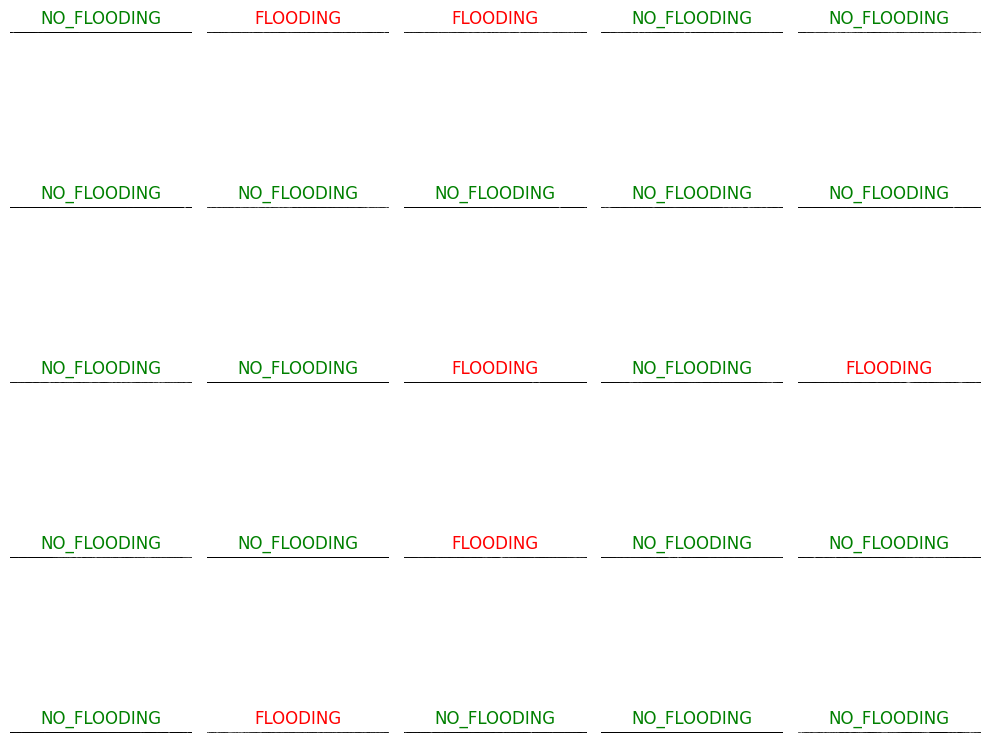

In [11]:
import matplotlib.pyplot as plt

batch = next(iter(ds.test_dataloader(shuffle=True, batch_size=25)))
imgs, labels = batch['image'], batch['label']

# compute predictions

preds = task.predict(batch)
preds = torch.argmax(preds, axis=1)

fig = plt.figure(figsize=(10, 10))
for i, (img, label, pred) in enumerate(zip(imgs, labels, preds)):
    ax = plt.subplot(5, 5, i + 1)
    if img.ndim == 2:
        ax.imshow(img, cmap="gray") # one band 
    else:
        ax.imshow(img[...,0], cmap="gray") # first band
    gt = ds.classes[label.item()]
    pred = ds.classes[pred.item()]
    ax.set_title(gt, color="green" if gt == pred else 'red')
    ax.axis('off')
plt.tight_layout()
plt.show()

## Sentinel-2

In [3]:
ds = SEN12Floods(batch_size=25,
                 verbose=True, 
                 sensor=Sensors.S2,
                 bands=[S2.RGB], 
                ) 

ds.setup()

Number of images: 2236
Training samples 1342
Validation samples 447
Test samples 447


All out datasets have a `DataFrame` containing the required data to train the model. In this case, the list of images and labels. Use this object to explore the dataset.

In [4]:
ds.df

,image,label
0,/Users/fran/Documents/datasets/sen12floods/sen...,0
1,/Users/fran/Documents/datasets/sen12floods/sen...,0
2,/Users/fran/Documents/datasets/sen12floods/sen...,1
3,/Users/fran/Documents/datasets/sen12floods/sen...,1
4,/Users/fran/Documents/datasets/sen12floods/sen...,0
...,...,...
2231,/Users/fran/Documents/datasets/sen12floods/sen...,0
2232,/Users/fran/Documents/datasets/sen12floods/sen...,0
2233,/Users/fran/Documents/datasets/sen12floods/sen...,0
2234,/Users/fran/Documents/datasets/sen12floods/sen...,0


In [5]:
ds.num_classes, ds.classes

(2, ['NO_FLOODING', 'FLOODING'])

Let's visualize some samples from the dataset. You can extract data from the `Dataset`s objects or the `DataLoaders`. `PytorchEO` is designed to work with arbitrary number of inputs and outputs, so we use a `dict` to name the different tensors.

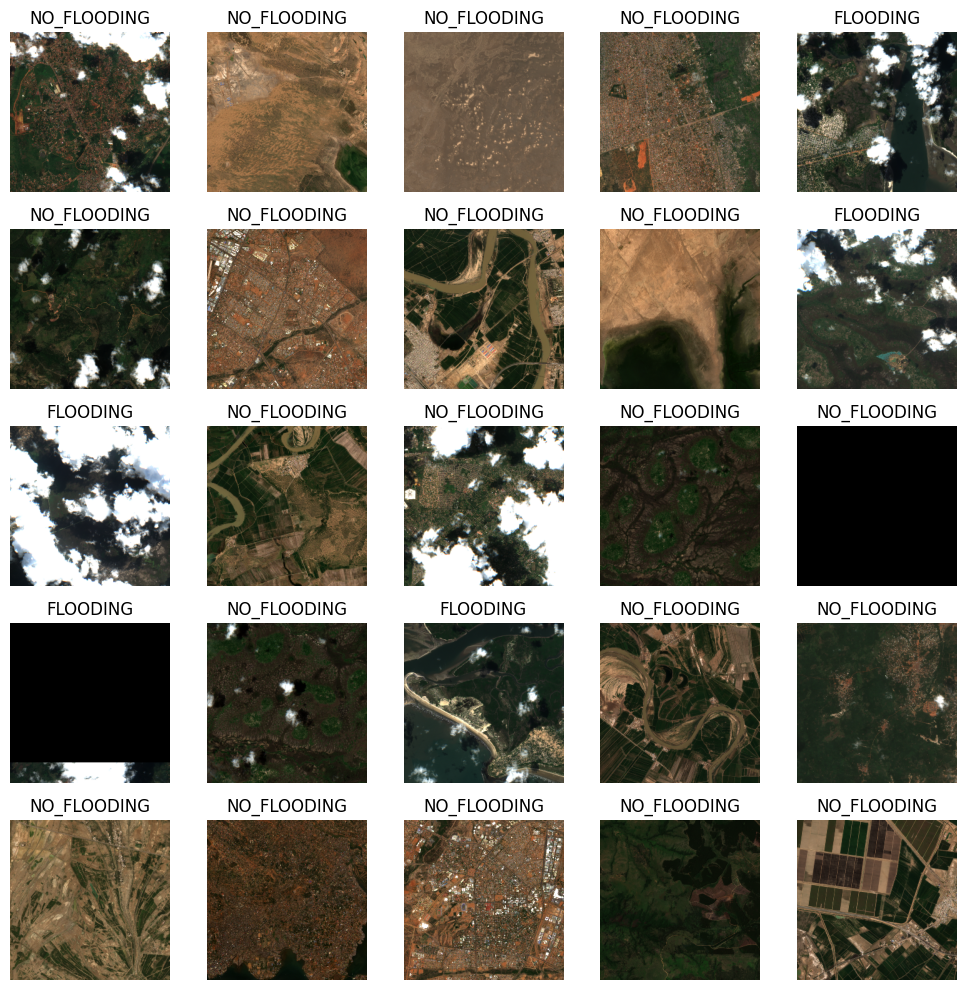

In [16]:
import matplotlib.pyplot as plt

# extract a batch of samples (you can also access val_dataloader or test_dataloader for the other splits)

batch = next(iter(ds.train_dataloader()))
imgs, labels = batch['image'], batch['label']

fig = plt.figure(figsize=(10, 10))
for i, (img, label) in enumerate(zip(imgs, labels)):
    ax = plt.subplot(5, 5, i + 1)
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(ds.classes[label.item()])
    ax.axis('off')
plt.tight_layout()
plt.show()

Let's train an image classifier on this dataset. To do so, we need to define a `task`. In this case, we use the `ImageClassification` task.

In [6]:
import torch 
from pytorch_eo.tasks.classification import ImageClassification

task = ImageClassification(num_classes=ds.num_classes)

output = task(torch.randn(8, 3, 224, 224))
output.shape

torch.Size([8, 2])

Now, we can use `Pytorch Lightning` for solving the `task` on the given `dataset`.

In [7]:
import lightning as L

trainer = L.Trainer(
    accelerator="cpu",
    devices=1,
    max_epochs=5,
)

trainer.fit(task, ds)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/fran/Documents/Projects/pytorchEO/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/fran/Documents/Projects/pytorchEO/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(

Number of images: 2236
Training samples 1342
Validation samples 447
Test samples 447
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/fran/Documents/Projects/pytorchEO/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/fran/Documents/Projects/pytorchEO/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 4: 100%|██████████| 54/54 [02:23<00:00,  2.66s/it, v_num=13, loss=0.468, acc=0.706, val_loss=0.578, val_acc=0.743]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 54/54 [02:23<00:00,  2.67s/it, v_num=13, loss=0.468, acc=0.706, val_loss=0.578, val_acc=0.743]


Once the model is trained, we can evaluate it on the test set to compute the final metrics.

In [8]:
trainer.test(dataloaders=ds.test_dataloader())

/Users/fran/Documents/Projects/pytorchEO/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at /Users/fran/Documents/Projects/pytorchEO/examples/lightning_logs/version_13/checkpoints/epoch=4-step=270.ckpt
Loaded model weights from the checkpoint at /Users/fran/Documents/Projects/pytorchEO/examples/lightning_logs/version_13/checkpoints/epoch=4-step=270.ckpt
/Users/fran/Documents/Projects/pytorchEO/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. C

Number of images: 2236
Training samples 1342
Validation samples 447
Test samples 447
Testing DataLoader 0: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7785235047340393     │
│         test_loss         │    0.4915841221809387     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.4915841221809387, 'test_acc': 0.7785235047340393}]

And also use it to predict labels on new images.

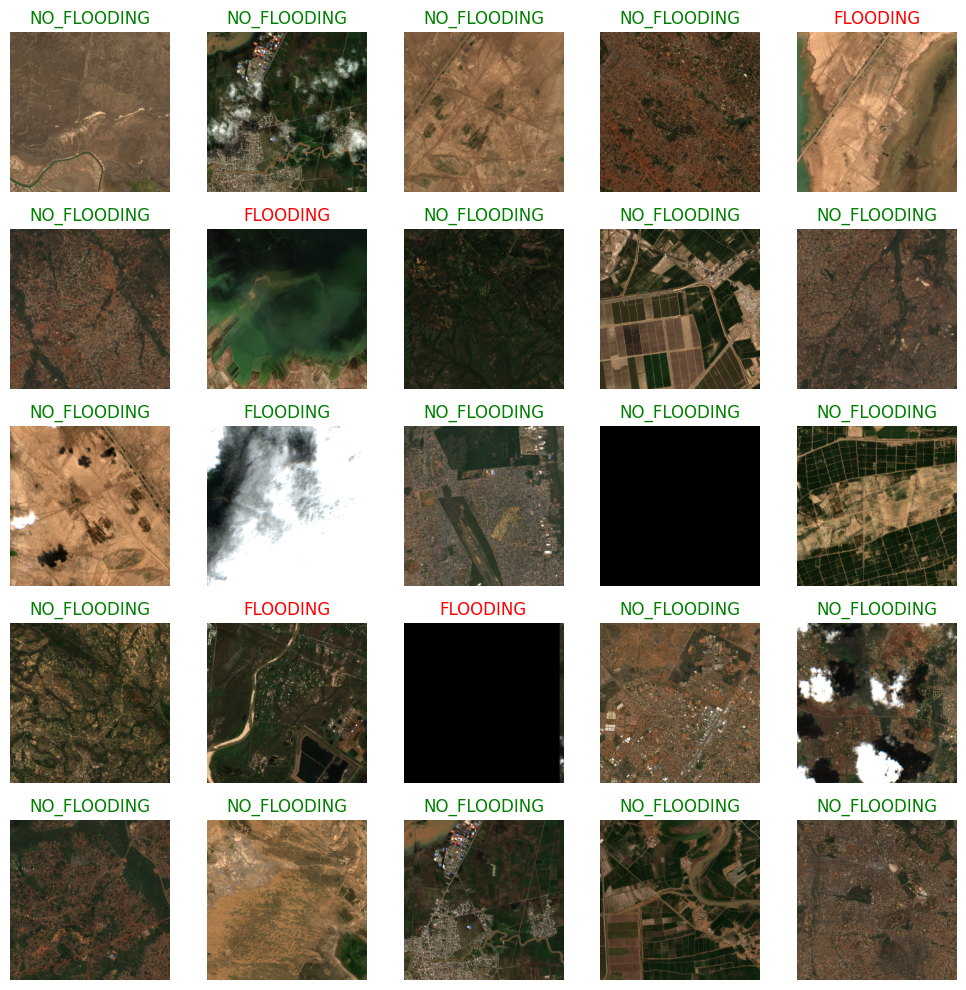

In [17]:
import matplotlib.pyplot as plt

# extract batch from test dataloader

batch = next(iter(ds.test_dataloader(shuffle=True, batch_size=25)))
imgs, labels = batch['image'], batch['label']

# compute predictions

preds = task.predict(batch)
preds = torch.argmax(preds, axis=1)

# visualize predictions

fig = plt.figure(figsize=(10, 10))
for i, (img, label, pred) in enumerate(zip(imgs, labels, preds)):
	ax = plt.subplot(5, 5, i + 1)
	ax.imshow(img.permute(1,2,0))
	gt = ds.classes[label.item()]
	pred = ds.classes[pred.item()]
	ax.set_title(gt, color="green" if gt == pred else 'red')
	ax.axis('off')
plt.tight_layout()
plt.show()